In [22]:
%matplotlib inline
import matplotlib.pyplot as plt
import os
import sys
from os.path import dirname
import pickle
import pandas as pd
import glob
import shapely
from shapely import geometry,ops
import numpy as np
import matplotlib.cm as cm
import seaborn
import datetime
import pyproj
import geopandas as gp
site_data = gp.read_file('./USGS_Streamgages-NHD_Locations.shp')
newman_df = pickle.load(open('/Users/daviddralle/Desktop/newman_df.p','rb'))

In [10]:
# get paths to streamflow data for each Newman basin
folders = os.listdir('./usgs_streamflow')
fh = []
fh = [folders[i] for i in range(len(folders)) if len(folders[i])==2]

flow_files = []
for f in fh: 
    try:
        
        flow_files.append(glob.glob('./usgs_streamflow/' + f + '/*.txt'))
    except RuntimeError:
        print 'Cannot find streamflow file.'
        
flow_files = [item for sublist in flow_files for item in sublist]

In [77]:
dates = []
qinc_anomaly = []
T_anomaly = []
P_anomaly = []
meantemp_color = []

for fh in flow_files[0:20]:
    site = fh.split('/')[-1][:8]
    weather = pickle.load( open('./daymet_newman/'+site+'_daymet.p', 'rb') )
    weather['tmean'] = (weather.tmax + weather.tmin)/2.0
    df = pd.read_csv(fh, delim_whitespace=True, header=-1)
    df.columns = ['gagenum', 'Year', 'Month', 'Day', 'q', 'e']
    df['date'] = df[['Year', 'Month', 'Day']].apply(lambda s : datetime.datetime(*s),axis = 1)
    df = df[['q', 'date']]
    df.set_index('date', inplace=True)
    df['date'] = df.index
    df.q += 1e-12 # having flow exactly equal to zero can cause problems with logs
    df.q *= 2.447e9 #cm^3/day
    area = float(site_data['DA_SQ_MILE'].loc[site_data.SITE_NO==site])*2.58998811e10 #cm^2
    df.q = df.q/area # cm/day
    weather = weather.loc[df.index]
    weather = weather.loc[df.q>0]
    df = df.loc[df.q>0]
    
    diffq = np.diff(df.q)
    mean_qinc = np.mean(diffq[diffq>0])
    meantemp = np.mean(weather.tmean)
    meanprcp = np.mean(weather.prcp.loc[weather.prcp>0])
    
    for year in list(set(df.index.year)):
        if len(df.loc[df.index.year==year])<365: 
            continue
        dftemp = df.loc[df.index.year==year]
        weathertemp = weather.loc[weather.index.year==year]
        diffq = np.diff(dftemp.q)
        qinctemp = np.mean(diffq[diffq>0])
        qinc_anomaly.append((qinctemp-mean_qinc)/mean_qinc)
        tmeantemp = np.mean(weathertemp.tmean)
        T_anomaly.append((tmeantemp-meantemp)/meantemp)
        meanprcptemp = np.mean(weathertemp.prcp.loc[weathertemp.prcp>0])
        P_anomaly.append((meanprcptemp-meanprcp)/meanprcp)
        meantemp_color.append(meantemp)
        
        
        
        
        
        
        
    

<function matplotlib.pyplot.colorbar>

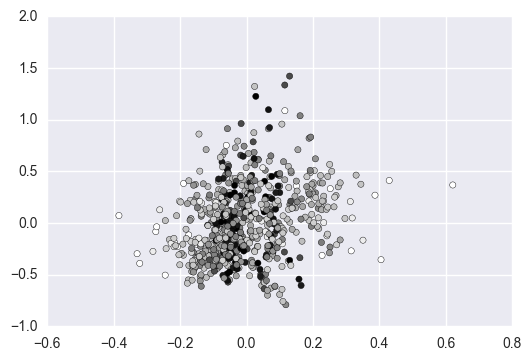

In [79]:
plt.scatter(T_anomaly, qinc_anomaly, c=meantemp_color)
plt.colorbar